In [1]:
import sys
sys.path.append("..")

import dataInterpreter as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score

In [4]:
data = dt.get_data('NHBE', 'healthy', 'sars-cov2', series = (1,))
columns_healthy = dt.get_columns('NHBE', 'healthy', series = (1,))
columns_sars_cov2 = dt.get_columns('NHBE', 'sars-cov2', series = (1,))

filtered_data = dt.get_p_values('mannwhitneyu', data, columns_healthy, columns_sars_cov2)
filtered_data

,Series1_NHBE_Mock_1,Series1_NHBE_Mock_2,Series1_NHBE_Mock_3,Series1_NHBE_SARS-CoV-2_1,Series1_NHBE_SARS-CoV-2_2,Series1_NHBE_SARS-CoV-2_3,p-value
SMIM1,1.609438,1.791759,1.945910,2.079442,2.397895,2.484907,0.040428
CA6,0.000000,0.000000,0.000000,0.693147,0.693147,1.098612,0.029673
C1orf127,0.000000,0.000000,0.000000,1.098612,1.386294,0.693147,0.031801
WNT4,4.262680,4.553877,4.615121,5.209486,4.844187,5.451038,0.040428
IFI6,3.912023,4.521789,3.637586,5.337538,5.455321,6.816736,0.040428
...,...,...,...,...,...,...,...
SLC6A14,6.714171,6.579251,7.250636,7.445418,7.371489,8.591187,0.040428
MIR503,1.386294,1.098612,1.098612,0.693147,0.000000,0.000000,0.036099
MCF2,2.397895,3.178054,3.332205,2.302585,1.609438,2.197225,0.040428
PNMA3,0.000000,0.000000,0.000000,0.693147,0.693147,1.791759,0.029673


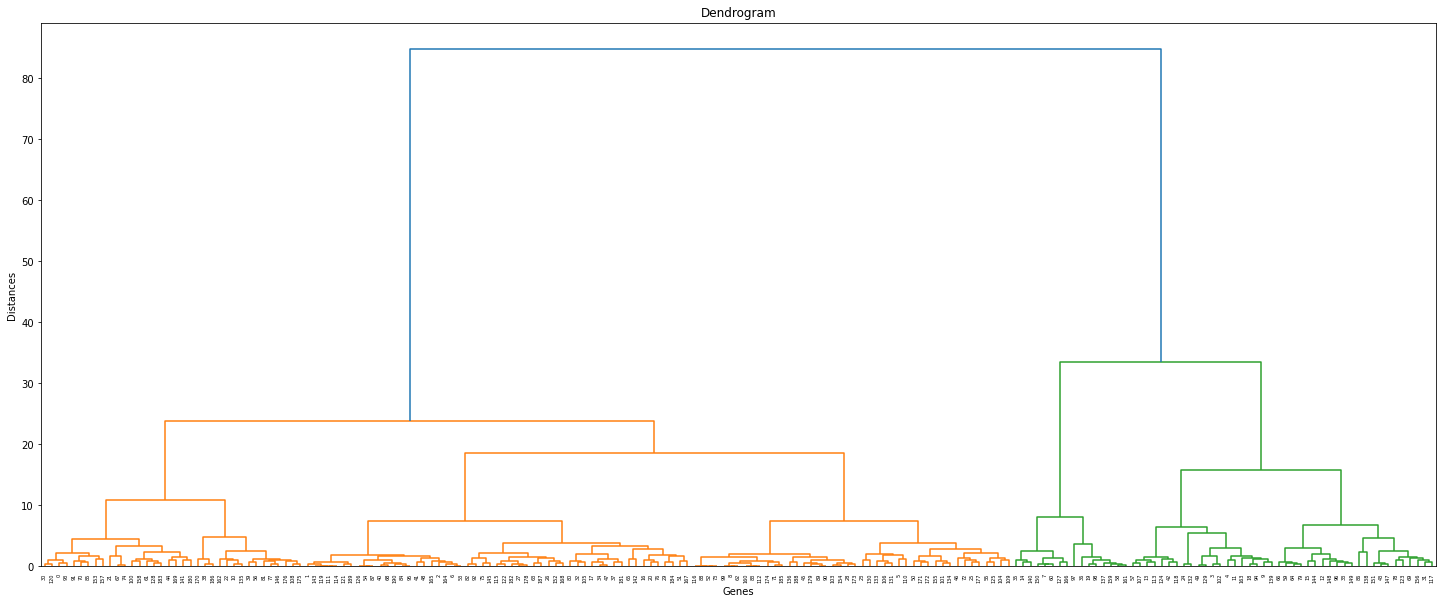

In [16]:
filtered_data.drop(['p-value'], axis = 1, inplace = True)
dt.plot_dendrogram(filtered_data)

In [5]:
labels = {}

models = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
labels['distance'] = models.fit_predict(filtered_data)

In [6]:
labels['distance']

array([0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 0,
       2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 1, 2, 2, 0, 1, 1, 0, 0, 0, 2, 2,
       2, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 2,
       1, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1,
       0, 2, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 2, 0, 2, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 1, 2, 0, 1, 1, 2,
       0, 2, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 0, 1, 0, 0, 1, 0, 2, 2, 1, 2,
       2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 2, 0, 0,

In [7]:
dissimilarity = 1 - np.abs(filtered_data.T.corr())
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['pearson'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [8]:
labels['pearson']

array([1, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 2,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       0, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1,
       1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 0, 1,
       0, 1, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0,
       1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1, 0, 1, 0,
       1, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 2, 2, 0, 1,
       2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 2,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 1, 2, 2, 2, 1,
       2, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,

In [9]:
dissimilarity = 1 - np.abs(filtered_data.T.corr(method='spearman'))
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['spearman'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [10]:
labels['spearman']

array([0, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2, 2, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2,
       0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 1, 2, 2, 2, 0, 1, 1, 0, 0, 1,

In [11]:
from itertools import groupby

clusters = {}

for key1, label1 in labels.items():
    clusters[key1] = [list(map(lambda x: x[0], v)) for k,v in groupby(sorted(zip(filtered_data.index, labels['spearman']), key = lambda x: x[1]), lambda s: s[1])]
    
    for key2, label2 in labels.items():
        if key1 != key2:
            print(key1, ' vs ', key2, ': ', adjusted_rand_score(label1, label2))

distance  vs  pearson :  0.20694204381146572
distance  vs  spearman :  0.06975670745033356
pearson  vs  distance :  0.20694204381146572
pearson  vs  spearman :  0.6096404056765685
spearman  vs  distance :  0.06975670745033356
spearman  vs  pearson :  0.6096404056765685


In [ ]:
i = 0
for c in clusters['distance']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['pearson']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['spearman']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [14]:
import enrichmentAnalysis as ea

results_enrichment = {'distance': [], 'pearson': [], 'spearman': []}

for cluster_type in clusters:
    for cluster in clusters[cluster_type]:
        results_enrichment[cluster_type] += [ea.getEnrichment(list(cluster), 'GO_Biological_Process_2021')['GO_Biological_Process_2021']]

results_enrichment

Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlap

{'distance': [[[1,
    'cytokine-mediated signaling pathway (GO:0019221)',
    1.4140202873333837e-27,
    10.3248322147651,
    638.3158251065183,
    ['IFITM3',
     'IFITM1',
     'CSF3',
     'CSF2',
     'ITGB2',
     'PDGFB',
     'IFI6',
     'CXCL1',
     'NOD2',
     'IFI35',
     'IFIT1',
     'CXCL3',
     'TNF',
     'CXCL2',
     'IFIT3',
     'CXCL5',
     'ICAM1',
     'SOCS3',
     'IRAK2',
     'MAP3K8',
     'STAT5A',
     'IL32',
     'TNFSF14',
     'CCL20',
     'MX2',
     'MX1',
     'LIF',
     'IL36G',
     'SOD2',
     'MMP9',
     'PSMB9',
     'BST2',
     'NFKBIA',
     'IL6',
     'IFI27',
     'OAS1',
     'OAS2',
     'IL1B',
     'OAS3',
     'SAA1',
     'LCN2',
     'IRF7',
     'LTB',
     'XAF1',
     'IRF9',
     'BIRC3'],
    2.3797961435820846e-24,
    0,
    0],
   [2,
    'cellular response to type I interferon (GO:0071357)',
    1.5242824702423362e-18,
    36.03876410899555,
    1478.4905817687363,
    ['IFITM3',
     'IFITM1',
     'MX2',
   

In [ ]:
import json

with open('results_NHBE.json', 'w') as file:
     file.write(json.dumps(results_enrichment)) # use `json.loads` to do the reverse

In [15]:
dataset = {'Adjusted p-value': [], 'Combined Score': [], 'Cluster': []}
index = []

for cluster_num in range(len(results_enrichment['distance'])):
    for term in results_enrichment['distance'][cluster_num]:
        index += [term[1]]
        dataset['Adjusted p-value'] += [term[6]]
        dataset['Combined Score'] += [term[4]]
        dataset['Cluster'] += [cluster_num]
enrichment_dataset = pd.DataFrame(dataset, index = index)

In [16]:
pd.set_option("display.max_rows", None)
selection = enrichment_dataset.sort_values('Adjusted p-value').head(25)

selection['Adjusted p-value'] = selection['Adjusted p-value'].map(lambda x: '%.2E' % x)
selection['Combined Score'] = selection['Combined Score'].map(lambda x: '%.2f' % x)

selection.to_csv('NHBE_table.csv')
selection

,Adjusted p-value,Combined Score,Cluster
cytokine-mediated signaling pathway (GO:0019221),2.38E-24,638.32,0
cellular response to type I interferon (GO:0071357),8.55E-16,1478.49,0
type I interferon signaling pathway (GO:0060337),8.55E-16,1478.49,0
defense response to symbiont (GO:0140546),1.88E-12,580.98,0
defense response to virus (GO:0051607),4.96E-12,516.27,0
inflammatory response (GO:0006954),3.21E-11,317.76,0
innate immune response (GO:0045087),5.79E-11,257.65,0
negative regulation of viral genome replication (GO:0045071),7.96E-10,722.58,0
cellular response to cytokine stimulus (GO:0071345),1.87E-09,157.69,0
response to cytokine (GO:0034097),3.44E-09,298.86,0


## Clustering on columns

NameError: name 'title' is not defined

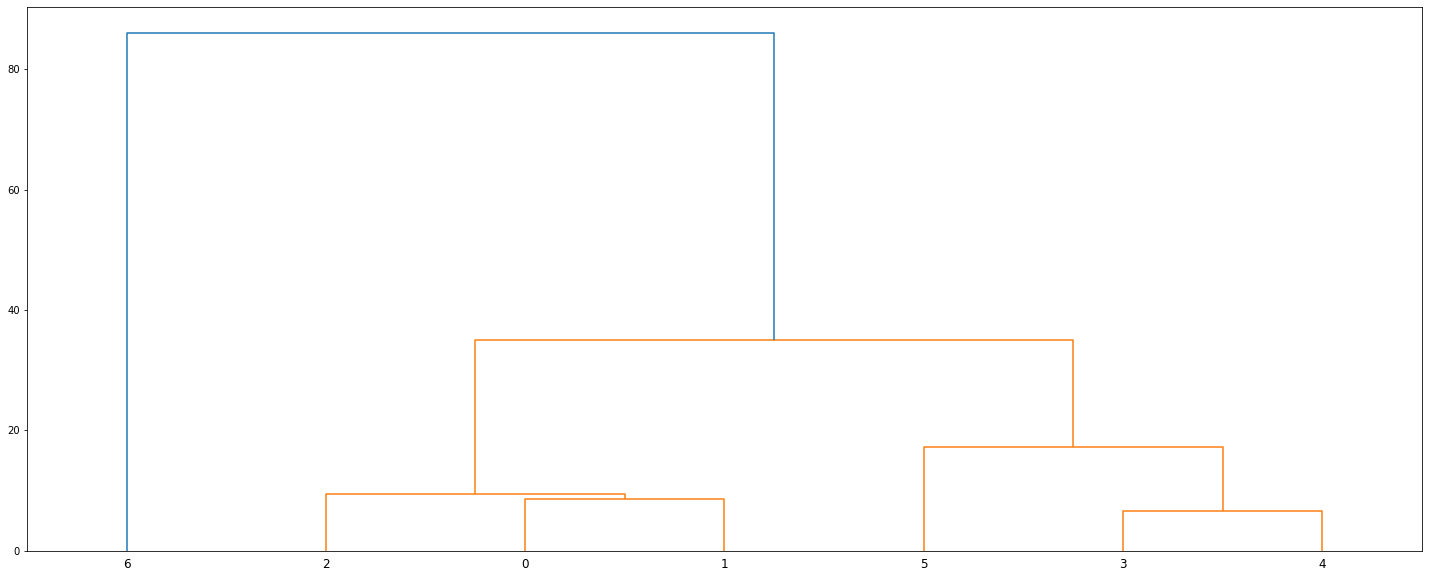

In [13]:
fig = plt.figure(figsize=(25, 10))
dendrogram = sch.dendrogram(sch.linkage(filtered_data.T, method="ward"))
plt.title(title)
plt.xlabel()
plt.ylabel('Distances')
plt.show()

In [108]:
labels_columns = {}

models = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
labels_columns['distance'] = models.fit_predict(filtered_data.T)

labels_columns['distance']

array([1, 1, 1, 0, 0, 0], dtype=int64)